In [2]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


In [355]:
PARAM_DICT = {
        'StringZ:aLund' : [0.5, 2.0],
        'StringZ:bLund': [0.5, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,4.0],
        'StringFlav:ProbStoUD':[0,4.0],
        'StringFlav:probQQtoQ':[0,4.0],
        'StringFlav:probSQtoQQ':[0,4.0],
        'StringFlav:ProbQQ1toQQ0':[0,4.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

15


In [386]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
    def uniform(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.tensor(np.random.uniform(
                low=PARAM_DICT[pre_postfix][0],
                high=PARAM_DICT[pre_postfix][1],
                size=self.size))

    def linspace(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.linspace(start=PARAM_DICT[pre_postfix][0],
                end=PARAM_DICT[pre_postfix][1],
                steps=self.size)


In [410]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactB = {rFactB}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [411]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [412]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

# Gaussian Process

In [413]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {best }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [414]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


In [362]:
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:100]
train_df.head()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,2,2,1.018815,1.907645,0.593628,1.285956,0.469747,0.616684,0.321632,0.093016,3.353963,2.502734,1.611805,3.728123,3.530520,0.150097,1.086739,38.989016
1,3,3,0.988716,0.471020,1.764055,0.462788,1.921271,0.872170,0.855325,0.969504,1.399415,3.818593,1.148781,2.588958,2.094627,0.114196,1.930516,40.164803
2,4,4,0.444193,1.834390,0.123916,1.964130,0.733800,1.430367,0.223075,0.812724,2.754028,3.016335,0.074418,0.043306,2.476595,0.100424,1.358620,29.317393
3,8,8,0.463673,1.647624,1.484369,0.706367,1.915505,1.579792,0.026979,0.088789,2.203874,3.153978,2.098117,0.935123,0.565346,0.126309,0.828173,42.062218
4,9,9,1.034734,1.489235,0.438249,0.517065,0.490425,1.223198,0.590138,0.841279,3.643448,3.529870,0.183085,1.555951,0.421221,0.160989,1.183123,39.716942


In [363]:
train_x = train_df[param_names].to_numpy()
train_y = train_df['chi2'].to_numpy()

In [364]:
train_x.shape

(100, 15)

In [365]:
train_y.shape

(100,)

In [366]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
    def uniform(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.tensor(np.random.uniform(
                low=PARAM_DICT[pre_postfix][0],
                high=PARAM_DICT[pre_postfix][1],
                size=self.size))

    def linspace(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.linspace(start=PARAM_DICT[pre_postfix][0],
                end=PARAM_DICT[pre_postfix][1],
                steps=self.size)

In [445]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        
        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [446]:
train_df_new = make_train_dataset(PARAM_DICT, 3)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine e374e0023fee (x86_64) at 2024-06-26 03:47:07
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-26 03:47:08
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-26 03:47:08, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.21it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.4   0.16  0.001783  0.001589         1.0
1  0.005  0.010   2.8   1.12  0.020927  0.032201         7.0
2  0.010  0.015   4.0   1.60  0.048273  0.118755        10.0
3  0.015  0.020   2.8   1.12  0.049038  0.172314         7.0
4  0.020  0.025   4.0   1.60  0.090683  0.414052        10.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

objective function = 5.838515247759653

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine e374e0023fee (x86_64) at 2024-06-26 03:47:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Finished event loop at 2024-06-26 03:47:11
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-26 03:47:11, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.12it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.8   0.32  0.002449  0.001499         2.0
1  0.005  0.010   2.4   0.96  0.017848  0.027708         6.0
2  0.010  0.015   4.0   1.60  0.051538  0.133326        10.0
3  0.015  0.020   7.2   2.88  0.124209  0.432330        18.0
4  0.020  0.025   6.4   2.56  0.145370  0.663280        16.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

objective function = 4.885546223257547

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine e374e0023fee (x86_64) at 2024-06-26 03:47:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Finished event loop at 2024-06-26 03:47:14
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-26 03:47:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 15.53it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh  sumw  sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   0.0   0.00  0.000000  0.000000         0.0
1  0.005  0.010   0.8   0.32  0.006467  0.010763         2.0
2  0.010  0.015   2.8   1.12  0.036073  0.094149         7.0
3  0.015  0.020   4.8   1.92  0.081926  0.280716        12.0
4  0.020  0.025   4.8   1.92  0.113190  0.535153        12.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01'

In [367]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [368]:
model.train_targets

tensor([38.9890, 40.1648, 29.3174, 42.0622, 39.7169, 31.4625, 42.8831, 45.3672,
        39.5386, 44.3275, 41.7051, 40.1208, 32.4868, 36.0973, 42.9459, 28.8990,
        43.5735, 30.1894, 38.5352, 44.2400, 35.6394, 38.6480, 33.8960, 54.1228,
        22.1227, 43.0421, 41.1442, 37.0642, 13.3339, 20.7982, 46.3051, 44.8764,
        43.5482, 47.7826, 36.8687, 28.3692, 34.5811, 41.0395, 39.4960, 47.8141,
        29.2369, 44.3195, 21.1419, 25.0382, 38.8303, 40.1730, 45.9197, 49.2347,
        44.9233, 33.1026, 32.8644, 48.0366, 34.8615, 29.6286, 17.2656, 47.6653,
        35.7567, 41.2666, 40.8341, 42.3546, 36.3700, 44.8925, 47.3488, 24.3999,
        44.9177, 40.3013, 19.1770, 39.1984, 37.1356,  9.9182, 41.1361, 17.7268,
        43.2468, 23.3593, 31.1856, 40.9859, 33.0537, 31.7131, 25.9044, 34.9342,
        40.9382, 56.4775, 39.3756, 47.2243, 37.5065, 27.8186, 43.0977, 32.8445,
        36.9007, 30.0534, 54.7204, 40.0547, 26.0889, 29.7730, 41.7839, 39.7291,
        39.5532, 38.5447, 26.9539, 42.65

In [369]:
model.train_inputs[0].shape

torch.Size([100, 15])

In [370]:
def make_x_candidates(PARAM_DICT, size):
    full_matrix = np.empty((size, len(PARAM_DICT)))
    
    for row in range(size):
        result=[]
        for key, val in PARAM_DICT.items():
            param_name, range_ = key, val
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            result.append(uniform_size_1)
        full_matrix[row,:] = result
        
    result = full_matrix
    
    # print(result)
    return torch.tensor(result)

In [371]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)

tensor([[0.3861, 0.0339, 0.4980, 0.9097, 1.6635, 0.2425, 0.1456, 0.7462, 2.3043,
         3.9973, 2.0352, 1.5945, 0.4045, 0.2448, 1.2920],
        [1.1860, 0.4160, 0.4075, 0.9422, 1.3435, 0.8942, 0.8030, 0.1766, 2.4535,
         1.5605, 3.5569, 2.0591, 3.5776, 0.1297, 0.1587]], dtype=torch.float64)


In [447]:
train_df_new

,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,0.594025,1.419220,0.969684,1.289911,1.130304,1.259239,0.788461,0.106638,2.895107,3.000485,1.112810,1.407219,2.840088,0.241678,0.181534,5.838515
1,0.504524,1.668715,0.459564,1.690104,1.522472,0.135011,0.485206,0.468572,1.910955,1.327710,0.688175,3.719920,0.853306,0.226691,0.879960,4.885546
2,1.460273,0.414668,1.587578,0.768623,1.304680,1.838225,0.600028,0.184513,2.573785,3.882380,0.646981,3.879288,3.984086,0.204721,0.779661,7.708786


In [372]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([0.3861, 1.1860], dtype=torch.float64)


In [373]:
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([2]))

In [374]:
train_x.shape

torch.Size([100, 15])

In [375]:
def make_multidim_xstar(param,size):

    x_star0 = Sample_param(param,size).linspace()
    empty = np.ones((size,15))
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    print(empty)
    return torch.tensor(empty)

In [376]:
make_multidim_xstar(param='bLund',size=2)

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       dtype=torch.float64)

In [377]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()
    
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,200)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='Mean Prediction')
    # plt.fill_between(x_star_aLund.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data')
    plt.legend()
    plt.show()

[[0.         1.         1.         ... 1.         1.         1.        ]
 [0.01005025 1.         1.         ... 1.         1.         1.        ]
 [0.0201005  1.         1.         ... 1.         1.         1.        ]
 ...
 [1.97989953 1.         1.         ... 1.         1.         1.        ]
 [1.9899497  1.         1.         ... 1.         1.         1.        ]
 [2.         1.         1.         ... 1.         1.         1.        ]]
(200,)


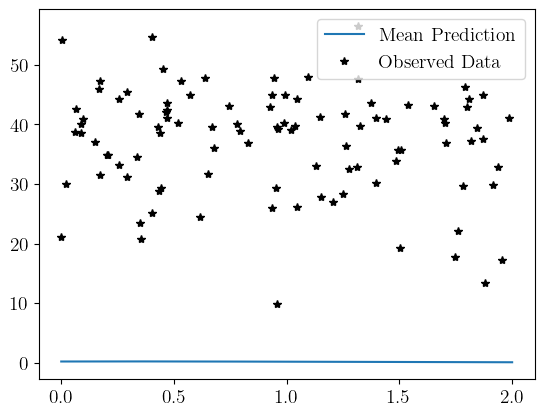

In [378]:
plot_model_param(model, 'aLund')

In [379]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [380]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


In [381]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
    #     if print_:
    #             print('Epoch %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     epoch + 1, n_epochs, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.items(),
    #     model.likelihood.noise.item()
    # ))
        loss.backward()
        optimizer.step()

In [382]:
train_model(model, train_x, train_y, 500,print_=True)

In [383]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([4.6952], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(4.8273, dtype=torch.float64)
covar_module.raw_outputscale tensor(4.6144, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[3.3042, 1.9608, 3.7856, 3.9156, 3.5722, 3.7057, 1.1596, 3.1975, 3.1838,
         3.6156, 3.7110, 4.6915, 4.1781, 4.8204, 2.8674]], dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


[[0.         1.         1.         ... 1.         1.         1.        ]
 [0.01005025 1.         1.         ... 1.         1.         1.        ]
 [0.0201005  1.         1.         ... 1.         1.         1.        ]
 ...
 [1.97989953 1.         1.         ... 1.         1.         1.        ]
 [1.9899497  1.         1.         ... 1.         1.         1.        ]
 [2.         1.         1.         ... 1.         1.         1.        ]]
(200,)


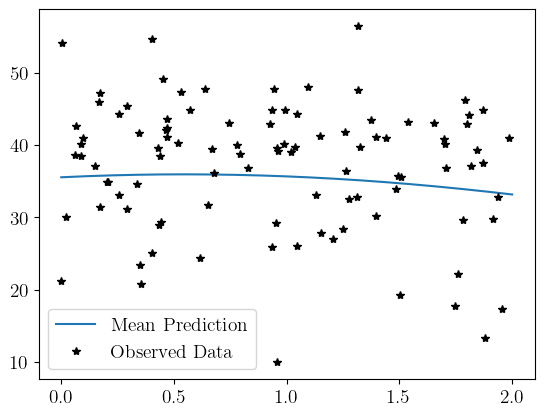

In [384]:
plot_model_param(model, 'aLund')